In [1]:
import noise
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon
from scipy.stats import kurtosis, skew

In [2]:
# wheel roulette function that returns index of probability map number
def roulette(probability_map):
    interval = random.uniform(0, sum(probability_map)) # all outcomes are equally likely
    for i, f in enumerate(probability_map):
        if interval <= 0:
            break
        interval -= f
    return i

In [3]:
def nearest(array, value):
    array = np.asarray(array)
    index = (np.abs(array - value)).argmin()
    return array[index]

## Perlin noise parameters

P_noise values generated acording to the code from {https://medium.com/@yvanscher/playing-with-perlin-noise-generating-realistic-archipelagos-b59f004d8401}

scale: number that determines at what distance to view the noisemap.

octaves: the number of levels of detail you want you perlin noise to have.

lacunarity: number that determines how much detail is added or removed at each octave (adjusts frequency).

persistence: number that determines how much each octave contributes to the overall shape (adjusts amplitude).

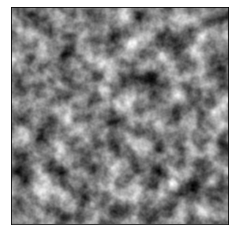

In [4]:
shape = (500,500)
scale = 50.0 
octaves = 4 # how detailed the map will be
lacunarity = 2 # makes frequency grow. Level of detail
persistence = 0.5 # two high - noise, two low -washed-out. Better to keep under 1


P_noise = np.zeros(shape)

for i in range(shape[0]):
    for j in range(shape[1]):
        P_noise[i][j] = noise.pnoise2(i/scale, 
                                    j/scale, 
                                    octaves=octaves, 
                                    persistence=persistence, 
                                    lacunarity=lacunarity,
        
                                    repeatx=1024, 
                                    repeaty=1024, 
                                    base=0)     
fig = plt.imshow(P_noise, cmap ='gray', origin = 'lower')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

In [5]:
N = 100

The code below creates a list of coordinates of semi-random points in Perlin noise. 

In [6]:
P_noise = P_noise.round(6)
i = 0

Dim_1 = P_noise.ravel()
Dim_1[Dim_1<0] = 0 # all negative values to zeros. - To get empty background

SRP = np.zeros((N,)) # semi random points array
for x in range(N):
  value = roulette(Dim_1)
  number = P_noise.ravel()
  number = number[value]
  SRP[x] = number

Dim_1back = np.reshape(Dim_1, shape)
point_coord = []
i=0
while i < N:
  for x in SRP: 
    coords = np.column_stack(np.where(Dim_1back == nearest(Dim_1, x)))
    Dim_1 = np.delete(Dim_1, np.where(Dim_1 == x), axis=0)
    coords = [coords[0][0], coords[0][1]]
    point_coord.append(coords)
    i += 1
point_coord = np.asarray(point_coord)

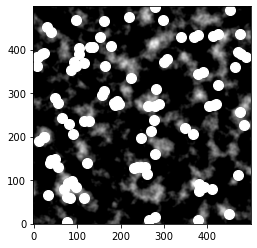

In [7]:
for x in point_coord:
  plt.plot(x[0],x[1], marker='o', color="w", markersize =10.0)    
fig = plt.imshow(Dim_1back, cmap='gray',  origin = 'lower')
#fig.axes.get_xaxis().set_visible(False)
#fig.axes.get_yaxis().set_visible(False)
#plt.gcf().set_size_inches((8, 8))
#plt.savefig('./voronoi_plots/Pridelioti.svg', format='svg', dpi = 300)
plt.show()

### Perlin noise after negative values become 0. 

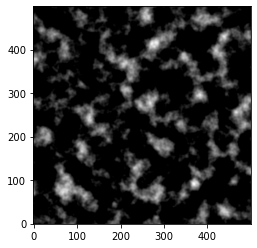

In [8]:
plt.imshow(Dim_1back, cmap ='gray', origin = 'lower')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.axis('on')
#plt.gcf().set_size_inches((8, 8))
#plt.savefig('./voronoi_plots/Prideliotiems.svg', format='svg', dpi = 300)
plt.show()

In [9]:
points = point_coord

In [10]:
##### uncomment for random distributed points####
#points = np.random.uniform(krastines_pradzia, krastines_ilgis, size=(N, 2)) 

In [11]:
krastines_pradzia = 0
krastines_ilgis = shape[0]
kvadrato_krastines_ilgis = abs(krastines_pradzia) +(krastines_ilgis)

In [12]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

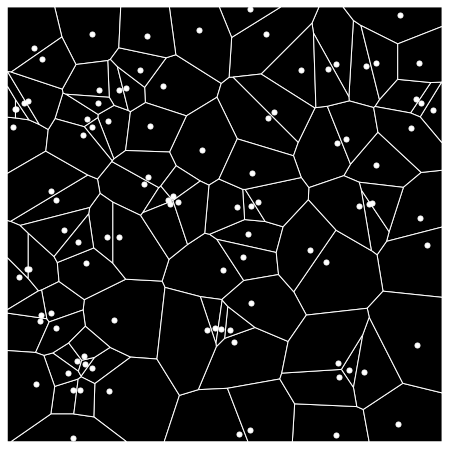

In [13]:
vor = Voronoi(points)

regions, vertices = voronoi_finite_polygons_2d(vor)

min_x = krastines_pradzia#vor.min_bound[0] 
max_x = krastines_ilgis#vor.max_bound[0] 
min_y = krastines_pradzia#vor.min_bound[1] 
max_y = krastines_ilgis#vor.max_bound[1] 

mins = np.tile((min_x, min_y), (vertices.shape[0], 1))
bounded_vertices = np.max((vertices, mins), axis=0)
maxs = np.tile((max_x, max_y), (vertices.shape[0], 1))
bounded_vertices = np.min((bounded_vertices, maxs), axis=0)

entropijai_visi = []

box = Polygon([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]])

visi_poly=[]

for region in regions:
    polygon = vertices[region]
    # Clipping polygon
    poly = Polygon(polygon)
    poly = poly.intersection(box)
    polygon = [p for p in poly.exterior.coords]
    entropijai_visi.append(polygon)
    koordinates = Polygon(polygon) 
    poligono_plotas = koordinates.area    
    visi_poly.append(poligono_plotas)
    plt.fill(*zip(*polygon),facecolor='black',  edgecolor='white', linewidth=1)#FFFF99
    
plt.plot(points[:, 0], points[:, 1],'o',color = 'white', markersize =5.0)#1f77b4
plt.axis('off')
plt.axis('equal')
plt.xlim(krastines_pradzia, krastines_ilgis)
plt.ylim(krastines_pradzia, krastines_ilgis)

plt.gca().set_aspect('equal', adjustable='box')
plt.gcf().set_size_inches((15, 8))
#plt.savefig('./voronoi_plots/100WB.svg', format='svg', dpi = 1600)
plt.show()

Pradinis poligonu skaicius 86
Svaraus listo ilgis 71


<ipython-input-14-cc8b9fb98ab7>:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


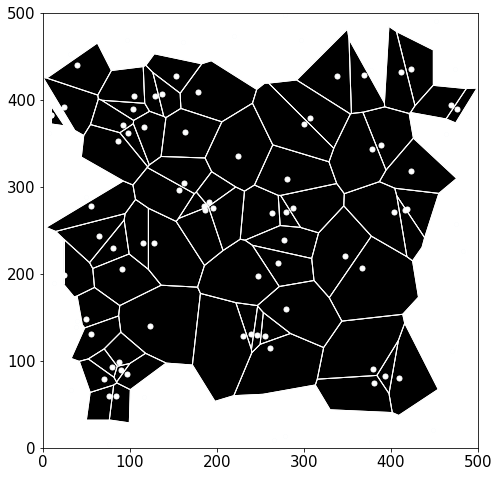

In [14]:
vor = Voronoi(points)
voronoi_plot_2d(vor,show_vertices = False, color='w', line_colors='w')

entropijai_nesiribojantys = []

visu_polygonu_plotai = []
visi_polygonai = []
for region in vor.regions:
  if not -1 in region :
    polygon = [vor.vertices[i] for i in region]
    koordinates = Polygon(polygon) 
    poligono_plotas = koordinates.area    
    visu_polygonu_plotai.append(poligono_plotas)
    visi_polygonai.append(polygon)

print('Pradinis poligonu skaicius',len(visi_polygonai))
visi_polygonai.remove([])
Svarus = []
pilnai_matomu_polygonu_plotai = []
for x in visi_polygonai:
  listukas =[a.tolist() for a in x]
  sarasas =[item for sublist in listukas for item in sublist]
  didesni = [a for a in sarasas if a > krastines_ilgis]
  minusiniai = [b for b in sarasas if b < krastines_pradzia]
  if len(minusiniai) ==0 and len(didesni) ==0:
    Svarus.append(x)
 
for x in Svarus:
  koord = Polygon(x)
  entropijai_nesiribojantys.append(len(x))
  poligono_plotas = koord.area
  pilnai_matomu_polygonu_plotai.append(poligono_plotas)
  plt.fill(*zip(*x), facecolor='black', edgecolor='white',linewidth=1)#FFFF99
print('Svaraus listo ilgis', len(Svarus))

box = Polygon([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]])
plt.plot(points[:, 0], points[:, 1],'o',color = 'white', markersize =5.0)#1f77b4
ax = plt.axes()
plt.xlim(krastines_pradzia, krastines_ilgis)
plt.ylim(krastines_pradzia, krastines_ilgis)
plt.axis('on')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#ax.set_xticks([])
#ax.set_yticks([])
plt.gca().set_aspect('equal', adjustable='box')
plt.gcf().set_size_inches((15, 8))
#plt.savefig('./Perlinparam/Random1000.svg', format='svg', dpi = 1000)

plt.draw()

In [15]:
import matplotlib.style
import matplotlib as mpl
print(plt.style.available) # see what styles are available
mpl.style.use('classic')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


## Histogram with all areas of Voronoi regions

No handles with labels found to put in legend.


Tasku skaicius = 100. Poligonu skaicius =  100
vidurkis 1.0
sigma 0.6690834862214242
kurtosis 0.0521304276903809
skewnes 0.758376586452573
Qskew 0.14911158319044435


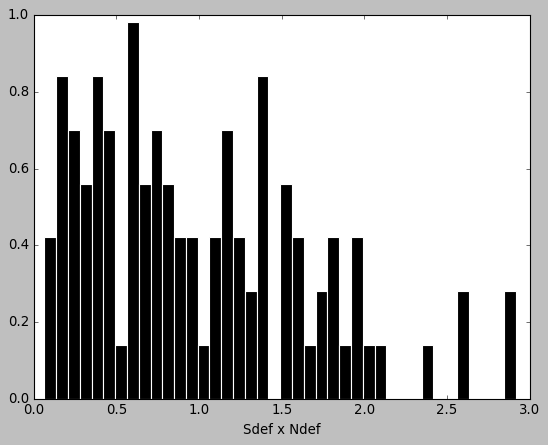

In [16]:
visi = []
for x in visi_poly:
  ikso_asis = x * (N/kvadrato_krastines_ilgis**2)
  visi.append(ikso_asis)
    
plt.hist(visi, density=True, bins=40, edgecolor="white", color='black', label='visi')
mu = np.mean(visi) # mean of distribution
sigma = np.std(visi) # standard deviation of distribution
kurtosi = kurtosis(visi)
skewness =skew(visi)
quartile_skew = np.percentile(visi, [25, 50, 75], interpolation='midpoint')
quartile_skew = (quartile_skew[2] - 2 * quartile_skew[1] + quartile_skew[0])/(quartile_skew[2]-quartile_skew[0])
#plt.text(2.5, 0.8, f'$\mu$={np.mean(Sdef_Ndef):5.4f}')
#plt.text(2.5, 1, f'$\sigma$={np.std(Sdef_Ndef):5.4f}')

ax.legend(bbox_to_anchor=(1, 0.99),fontsize=12, loc=2)
ax.set_facecolor('white')

#plt.gcf().set_size_inches((15, 8))

#plt.title(r'All sector area histogram $\mu$= %5.4f, $\sigma$= %5.4f' %(mu, sigma))
plt.xlabel('Sdef x Ndef')
print('Tasku skaicius = %s. Poligonu skaicius = '%N, len(visi))
print('vidurkis', mu)
print('sigma', sigma)
print('kurtosis', kurtosi)
print('skewnes', skewness)
print('Qskew', quartile_skew)
#plt.savefig('./voronoi_plots/VisuPoligonuPlotai_1000.svg', format='svg', dpi = 1600)   

## Histogram with inside areas of Voronoi regions

Is 100 poligonu, pilnu poligonu yra  71
vidurkis 1.0000000000000002
sigma 0.6948449275846629
kurtosis 0.3664466924664245
skewnes 0.9494020021677323
Qskew 0.0997954198524963


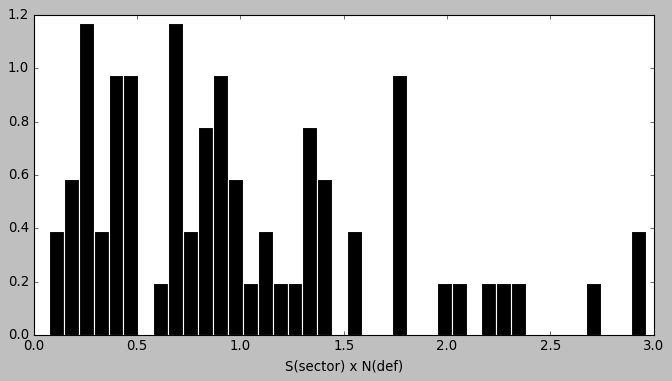

In [17]:
Sdef_Ndef = []
suma = sum(pilnai_matomu_polygonu_plotai)
full = len(pilnai_matomu_polygonu_plotai)
for x in pilnai_matomu_polygonu_plotai:
  ikso_asis = x * (full/suma)
  Sdef_Ndef.append(ikso_asis)

plt.gcf().set_size_inches((10, 5))
plt.hist(Sdef_Ndef, density=True, bins=40, edgecolor="white", color='black')
mu = np.mean(Sdef_Ndef) # mean of distribution
sigma = np.std(Sdef_Ndef)
kurtosiss = kurtosis(Sdef_Ndef)
skewness =skew(Sdef_Ndef)
quartile_skew = np.percentile(Sdef_Ndef, [25, 50, 75], interpolation='midpoint')
quartile_skew = (quartile_skew[2] - 2 * quartile_skew[1] + quartile_skew[0])/(quartile_skew[2]-quartile_skew[0])
#plt.title(r'Sector area histogram $\mu$= %5.4f, $\sigma$= %5.4f' %(mu, sigma))
plt.xlabel('S(sector) x N(def)')

#plt.savefig('./Perlinparam/Random_histo.svg', format='svg', dpi = 1600)    
print('Is %s poligonu, pilnu poligonu yra '%N, len(Sdef_Ndef))
print('vidurkis', mu)
print('sigma', sigma)
print('kurtosis', kurtosiss)
print('skewnes', skewness)
print('Qskew', quartile_skew)


In [18]:
poligonu_kampu_skaiciai = []
for x in entropijai_visi:
    poligonu_kampu_skaiciai.append(len(x))
print(len(poligonu_kampu_skaiciai))




100


## Voroonoi entropy


In [19]:
d1 = {i:poligonu_kampu_skaiciai.count(i) for i in poligonu_kampu_skaiciai}

d2 = dict((x,entropijai_nesiribojantys.count(x)) for x in set(entropijai_nesiribojantys))

In [20]:
def Voronoi_entropy(d):
    suma = 0
    for v in d.values():
        viso = sum(d.values())
        P = v/viso # apskaiciuojama kiekvieno poligono dalis visoje diagramoje
        P = -(P * np.log(P))
        print(suma)
        suma= suma + P
    return suma

# Vidiniai

In [21]:
entropija  = Voronoi_entropy(d2)
entropija

0
0.1336929966918256
0.4621358859747352
0.7822868108193097
1.1301959114476579
1.4410479784129695
1.6030978666338949
1.7367908633257205


1.7968286080727813

# Visi

In [22]:
Voronoi_entropy(d1)

0
0.04605170185988091
0.3995716982554967
0.7082354153120435
1.0168991323685903
1.1666857460462898
1.5091936713999248
1.6143904083195242


1.7431454413142522

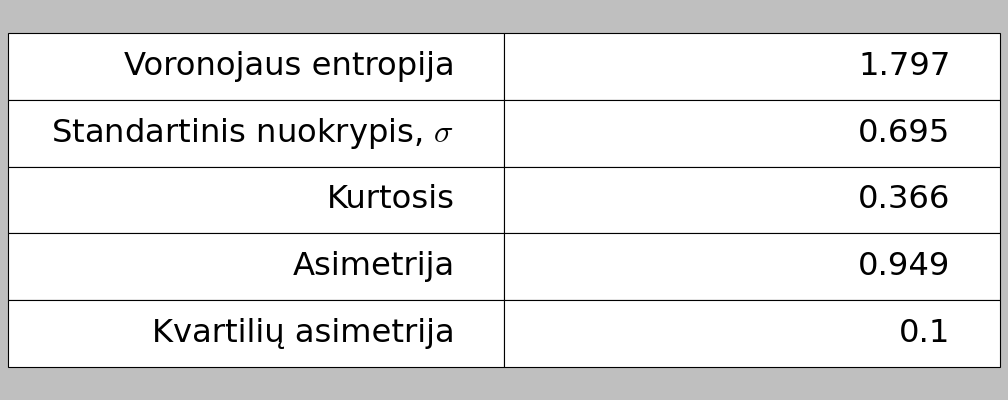

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

#define figure and axes
fig, ax = plt.subplots()

#create values for table
table_data=[
    ["Voronojaus entropija", entropija.round(3)],
    ["Standartinis nuokrypis, $\sigma$", sigma.round(3)],
    ["Kurtosis", round(kurtosiss, 3)],
    ["Asimetrija", round(skewness, 3)],
    ["Kvartilių asimetrija", quartile_skew.round(3)]
]

#create table
table = ax.table(cellText=table_data, loc='center')

#modify table
table.set_fontsize(30)
table.scale(2,5)
ax.axis('off')
#plt.savefig('./Perlinparam/Lakoniskumas_l2_p1_tble.svg', format='svg', dpi = 600,bbox_inches='tight') 
#display table
plt.show()